10
800
800
[ 9 10 11 12 13 14 15 16 17]
(800, 9)


/private/var/mobile/Containers/Data/Application/4907D989-2600-4E26-894D-F70A4156593C/tmp/ipykernel_6946/3519726914.py:147: RuntimeWarning: invalid value encountered in log
  phi_rpt[:,i]=np.log(eff0/eff_rpt[:,i])/beta/(1+np.log(eff0/eff_rpt[:,i])/beta)


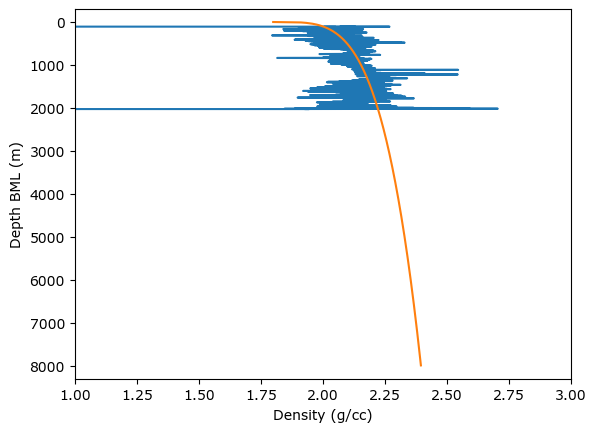

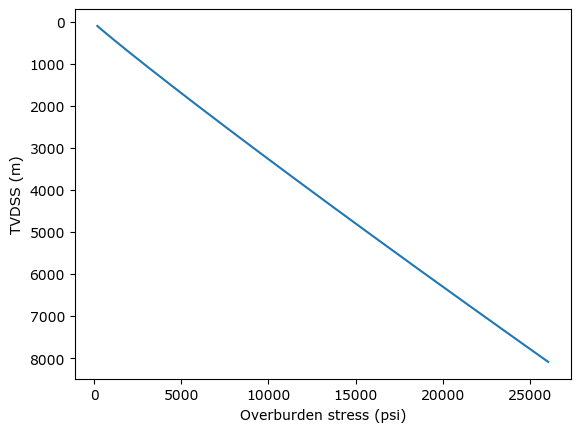

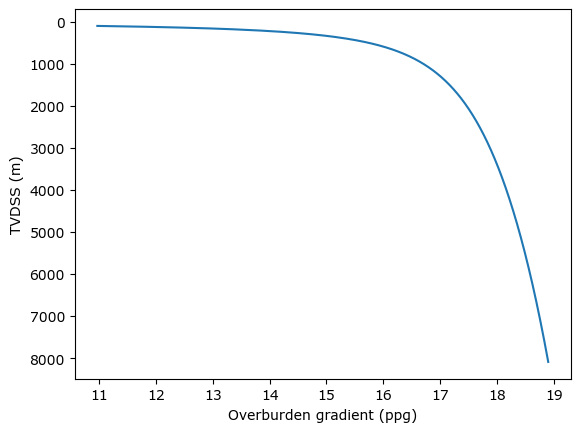

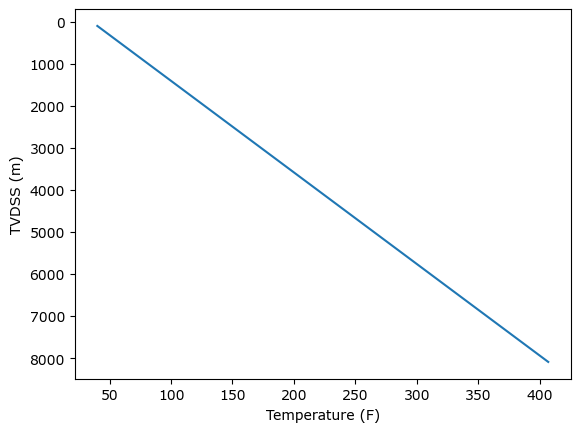

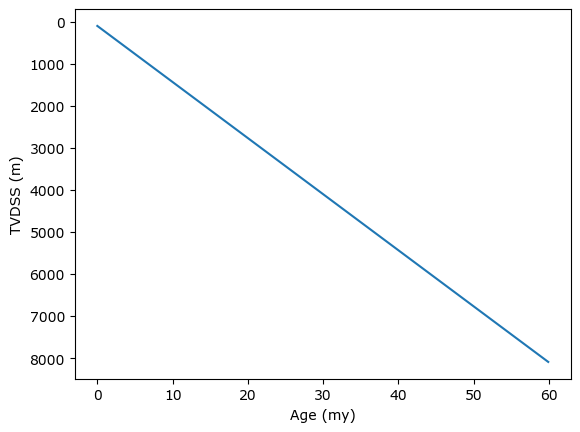

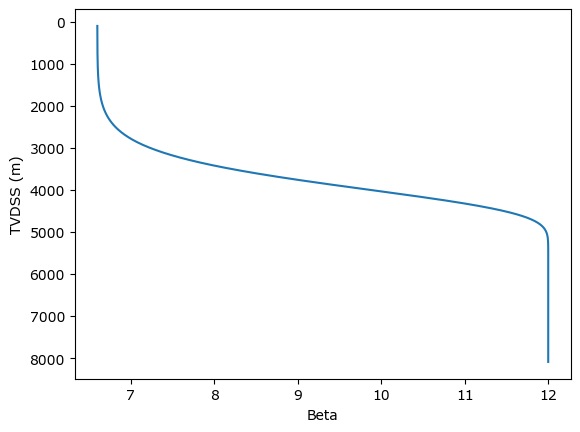

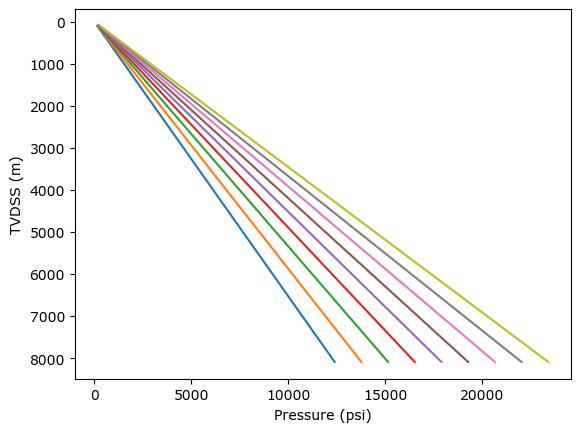

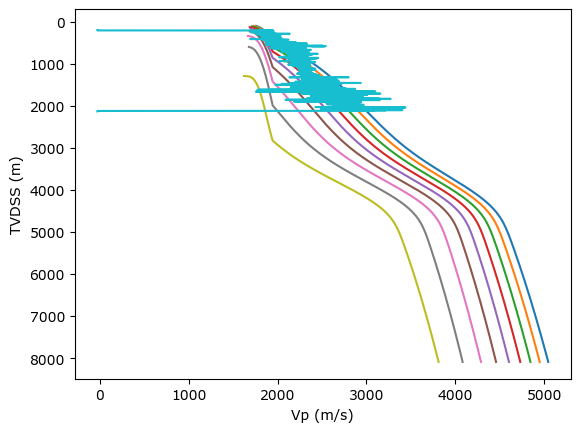

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load in a log data and overlay with vp_rpt

b=np.loadtxt('Well-1_LQC_las.txt')
z=b[:,0]
dt=b[:,4]
dts=b[:,5]
gar=b[:,6]
rhob=b[:,11]
vp_sonic=1e6/dt/3.2808
vs_sonic=1e6/dts/3.2808

zbml=np.arange(0,8000,10)
wd=100 # Sea water depth, m
row=1.03 # Sea water density, g/cc

# Density trend, Traugott eq, to be calibrated
rosfl=1.8
a=0.35
b=0.25
c=3125

ro=rosfl+a*(zbml*3.2808/c)**b

plt.figure()
plt.plot(rhob,z-wd)
plt.plot(ro,zbml)
plt.xlabel('Density (g/cc)')
plt.ylabel('Depth BML (m)')
plt.axis([1,3,-300,8300])
plt.gca().invert_yaxis()


# Convert density trend to overburden stress

atms2psi = 14.69595
gcc2psift=0.4332
# 1gcc=0.4332psi/ft
psift2ppg = 19.27 
# 1psi/ft=19.27ppg

dz=zbml[1]-zbml[0]

ob=np.cumsum(ro)*gcc2psift*3.2808*dz+atms2psi+wd*row*gcc2psift*3.2808
obg=ob/((zbml+wd)*3.2808)*psift2ppg

plt.figure()
plt.plot(ob,zbml+wd)
plt.xlabel('Overburden stress (psi)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()

plt.figure()
plt.plot(obg,zbml+wd)
plt.xlabel('Overburden gradient (ppg)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()

print(dz)

# Temperature

tg=0.014 # thermal gradient F/ft, GOM average 0.014-0.016 F/ft
t0=40 # Seafloor temperature F
temp=t0+tg*zbml*3.2808

plt.figure()
plt.plot(temp,zbml+wd)
plt.xlabel('Temperature (F)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()

# Geologic age

age=np.interp(zbml,[0,8000],[0,60])

plt.figure()
plt.plot(age,zbml+wd)
plt.xlabel('Age (my)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()

# Beta function

print(temp.size)
print(age.size)

R = 1.987 #cal/K/mol
dE = 19.39e3 #cal/mol (Dutta: 19.3+-0.7 kcal/mol)
A = 4e10 #/million yrs (Dutta: 0.4/yr)
b0=6.6
b1=12

dt = np.diff(age)
dt = np.insert(dt, 0, 0)

Tk=(5/9)*(temp-32)+273.15 # Convert temp from F to K

S = A * np.exp(-dE / R / Tk) * dt
S = np.cumsum(S)
S = 1 * np.exp(-S)

beta=b0*S+b1*(1-S)
     
plt.figure()
plt.plot(beta,zbml+wd)
plt.xlabel('Beta')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()

# Calculate Shale RPT
eff0=27500

# Calculate assumed PPG and Effective stress curves
ppg=np.arange(9,18,1)
pp_rpt=np.zeros((len(zbml),len(ppg)))
eff_rpt=np.zeros((len(zbml),len(ppg)))

for i in range(len(ppg)):
    pp_rpt[:,i]=ppg[i]/psift2ppg*(zbml+wd)*3.2808 # pp rpt in psi
    eff_rpt[:,i]=ob-pp_rpt[:,i]
    
plt.figure()
plt.plot(pp_rpt,zbml+wd)
plt.xlabel('Pressure (psi)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()

'''
plt.figure()
plt.plot(eff_rpt,zbml+wd)
plt.xlabel('Effective stress (psi)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()
'''

print(ppg)
print(eff_rpt.shape)

# Convert Effective Stress to Porosity using Dutta's eq

phi_rpt=np.zeros((len(zbml),len(ppg)))

for i in range(len(ppg)):
    phi_rpt[:,i]=np.log(eff0/eff_rpt[:,i])/beta/(1+np.log(eff0/eff_rpt[:,i])/beta)

'''
plt.figure()
plt.plot(phi_rpt,zbml+wd)
plt.xlabel('Porosity')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()
'''

# Convert Porosity to Vp using Issler eq

dtm=53 # solid slowness, us/ft
xdt=2.3 # lithology coefficient

dt_rpt=dtm*(1-phi_rpt)**(-xdt)
vp_rpt=1e6/dt_rpt/3.2808

'''
plt.figure()
plt.plot(vp_rpt,zbml+wd)
plt.xlabel('Vp (m/s)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()
'''

# Correct shallow Vp using Reuss eq

dtf=204 # Water slowness
rom=2.65 # Solid density
rof=1.5 # Water density

kr=1/(dtm**2*(1-phi_rpt)/rom+dtf**2*phi_rpt/rof)
ror=rom*(1-phi_rpt)+rof*phi_rpt
dtr=np.sqrt(ror/kr)
vpr=1e6/dtr/3.2808

'''
plt.figure()
plt.plot(1e6/dtr,zbml+wd)
plt.xlabel('Vp (ft/s)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()
'''

idx = vp_rpt < vpr
vp_rpt[idx] = vpr[idx]

plt.figure()
plt.plot(vp_rpt,zbml+wd)
plt.plot(vp_sonic,z)
plt.xlabel('Vp (m/s)')
plt.ylabel('TVDSS (m)')
plt.gca().invert_yaxis()



800
12678


/private/var/mobile/Containers/Data/Application/4907D989-2600-4E26-894D-F70A4156593C/tmp/ipykernel_6946/1416774769.py:7: RuntimeWarning: invalid value encountered in power
  phi_sonic=1-(dtm/dt_sonic)**(1/xdt)


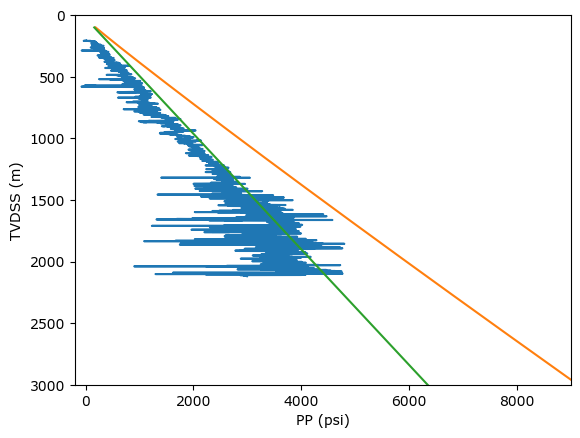

In [2]:
print(ob.size)
print(vp_sonic.size)

# Convert vp_sonic to pp

dt_sonic=1e6/vp_sonic/3.2808
phi_sonic=1-(dtm/dt_sonic)**(1/xdt)

vr=phi_sonic/(1-phi_sonic)

beta_interp=np.interp(z,zbml+wd,beta)
eff_sonic=eff0*np.exp(-vr*beta_interp)

ob_interp=np.interp(z,zbml+wd,ob) # interpolate ob to sonic depth

pp_sonic=ob_interp-eff_sonic

rosw=1.03 # seawater density, g/cc
hsg = rof*gcc2psift # hydraustatic gradient
poh = atms2psi + rosw*gcc2psift*wd*3.2808 + hsg*zbml*3.2808

plt.figure()
plt.plot(pp_sonic,z)
plt.plot(ob,zbml+wd)
plt.plot(poh,zbml+wd)
plt.xlabel('PP (psi)')
plt.ylabel('TVDSS (m)')
plt.axis([-200, 9000, 0, 3000])
plt.gca().invert_yaxis()


/private/var/mobile/Containers/Data/Application/4907D989-2600-4E26-894D-F70A4156593C/tmp/ipykernel_6946/3867445364.py:6: RuntimeWarning: invalid value encountered in power
  ro1=1.32+a1*(vp_sonic*3.2808-5000)**b1


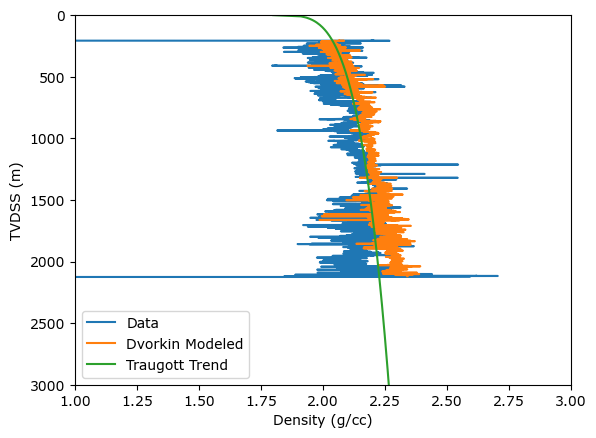

In [3]:
# Density from Vp using Dvorkin's eq

a1=0.15
b1=0.225

ro1=1.32+a1*(vp_sonic*3.2808-5000)**b1

plt.figure()
plt.plot(rhob,z,label='Data')
plt.plot(ro1,z,label='Dvorkin Modeled')
plt.plot(ro,zbml,label='Traugott Trend')
plt.xlabel('Density (g/cc)')
plt.ylabel('TVDSS (m)')
plt.legend()
plt.axis([1,3,0,3000])
plt.gca().invert_yaxis()

[   0    1    2 ... 5997 5998 5999]
[77.         76.97318137 76.94637548 ...         nan         nan
         nan]
Seafloor Temp F= 68.86809063611511


/private/var/mobile/Containers/Data/Application/4907D989-2600-4E26-894D-F70A4156593C/tmp/ipykernel_6946/2084228666.py:12: RuntimeWarning: invalid value encountered in power
  Tsfl=40+37*(1-0.00025*D)**2.9 # Estimate seafloor temp based on water depth


68.86809063611511
20.482272575619508
20.77417591110006
69.3935166399801


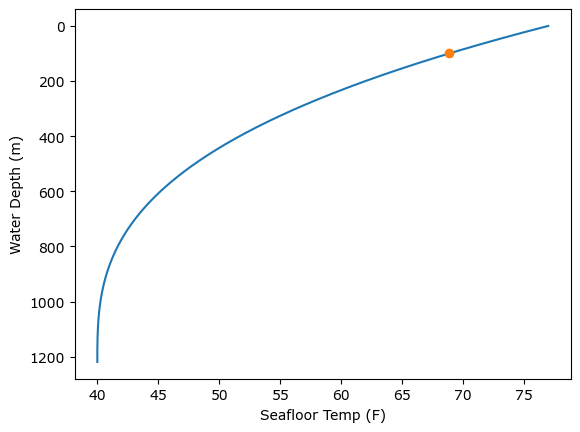

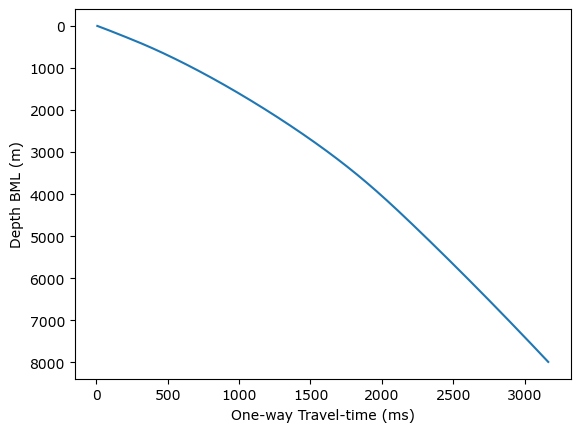

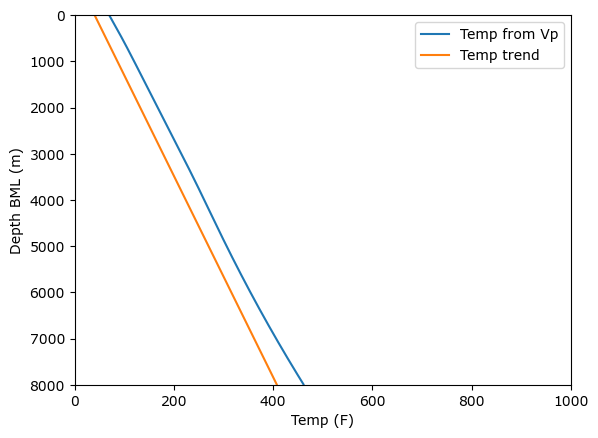

In [4]:
from f_to_c import f_to_c
from c_to_f import c_to_f

# Temperature from Vp using Liu et al 2021 March TLE

a2=1.349e-5
c2=80.031
q=27 # Heat flow, mW/m2
D=np.arange(0,6000) # Seafloor array in ft
print(D)

Tsfl=40+37*(1-0.00025*D)**2.9 # Estimate seafloor temp based on water depth
print(Tsfl)

Tsfl0=40+37*(1-0.00025*wd*3.2808)**2.9 # Estimate seafloor temp based on water depth
print('Seafloor Temp F=',Tsfl0)

plt.figure()
plt.plot(Tsfl,D/3.2808)
plt.plot(Tsfl0,wd,'o')
plt.xlabel('Seafloor Temp (F)')
plt.ylabel('Water Depth (m)')
plt.gca().invert_yaxis()

scalor=1.4 # scalor to scale hydrostatic velocity to calculate a calibrated travel-time below
tt=np.cumsum(dz/vp_rpt[:,0]*scalor)*1000 # Take a scaled hydrostatic Vp as input to calculate the one-way travel-time, ms

Tsfl0c=f_to_c(Tsfl0) # Using the defined function f_to_c to convert F to C, note, function file need to be saved as .py
print(Tsfl0)
print(Tsfl0c)

TC=(Tsfl0c+c2)*np.exp(a2*q*tt)-c2 # Equation defined in Liu et al 2021 March TLE, Unit is C

TF=c_to_f(TC) # Using the defined function c_to_f to convert C to F, note, function file need to be saved as .py
print(TC[0])
print(TF[0])

plt.figure()
plt.plot(tt,zbml)
plt.xlabel('One-way Travel-time (ms)')
plt.ylabel('Depth BML (m)')
plt.gca().invert_yaxis()

plt.figure()
plt.plot(TF,zbml,label='Temp from Vp')
plt.plot(temp,zbml,label='Temp trend')
plt.xlabel('Temp (F)')
plt.ylabel('Depth BML (m)')
plt.legend()
plt.axis([0,1000,0,8000])
plt.gca().invert_yaxis()


/private/var/mobile/Library/Mobile Documents/iCloud~AsheKube~Carnets/Documents/Rock_Physics/vpvs2pr.py:2: RuntimeWarning: divide by zero encountered in divide
  return (0.5*vpvs**2-1)/(vpvs**2-1)


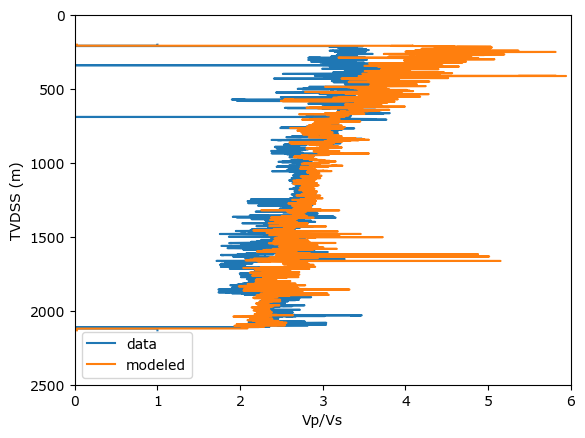

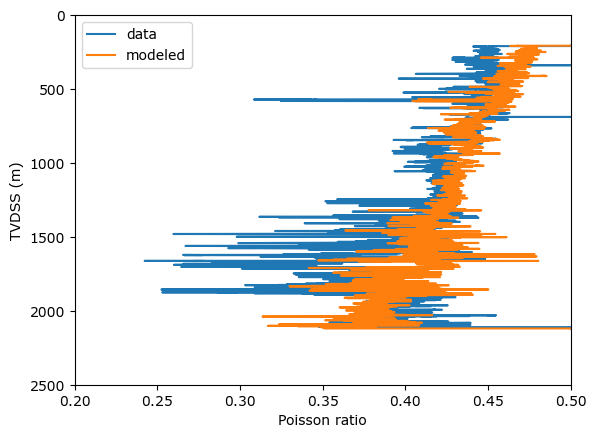

In [5]:
from vpvs2pr import vpvs2pr

# Vs from Vp using Castagna's Mud Rock Line

vs_modeled=(0.862*vp_sonic/1000-1.172)*1000

vpvs_data=vp_sonic/vs_sonic
vpvs_modeled=vp_sonic/vs_modeled
pr_data=vpvs2pr(vpvs_data)
pr_modeled=vpvs2pr(vpvs_modeled)

plt.figure()
plt.plot(vpvs_data,z,label='data')
plt.plot(vpvs_modeled,z,label='modeled')
plt.xlabel('Vp/Vs')
plt.ylabel('TVDSS (m)')
plt.axis([0,6,0,2500])
plt.legend()
plt.gca().invert_yaxis()

plt.figure()
plt.plot(pr_data,z,label='data')
plt.plot(pr_modeled,z,label='modeled')
plt.xlabel('Poisson ratio')
plt.ylabel('TVDSS (m)')
plt.axis([0.2,0.5,0,2500])
plt.legend()
plt.gca().invert_yaxis()

Text(0, 0.5, 'Velocity (km/s)')

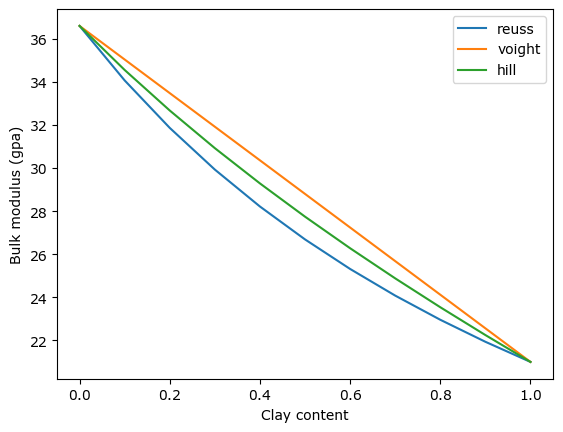

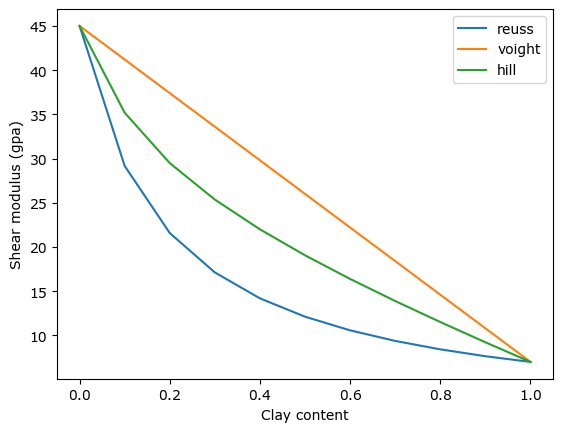

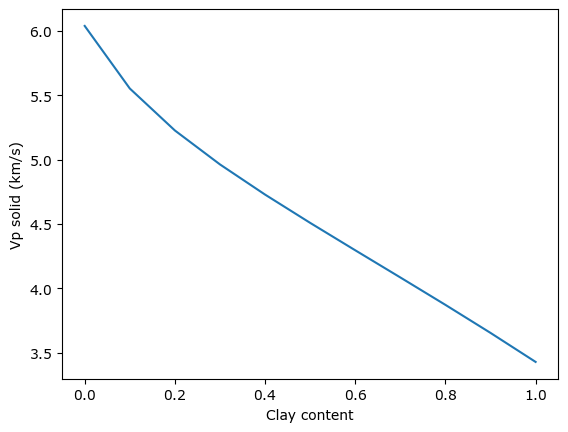

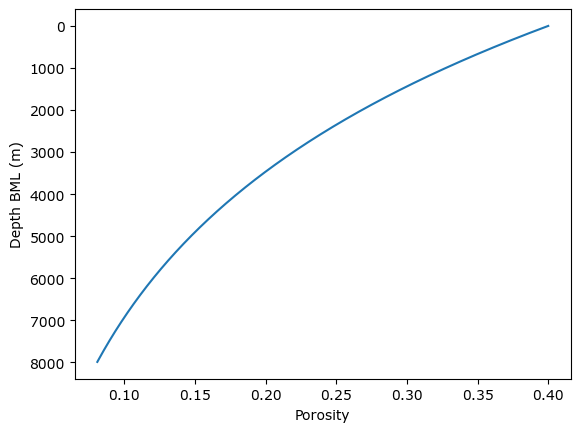

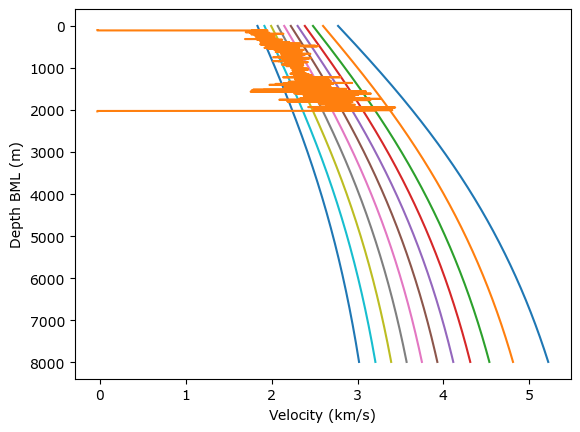

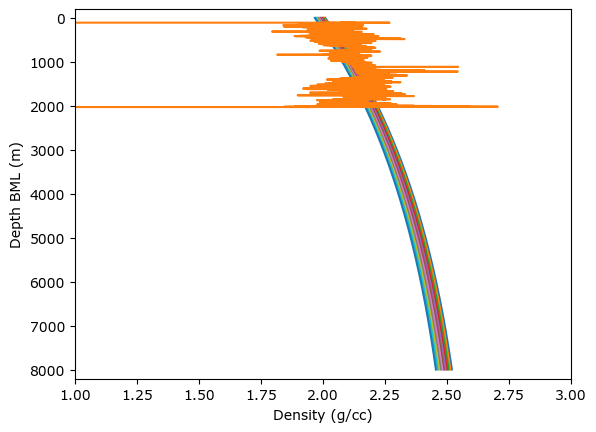

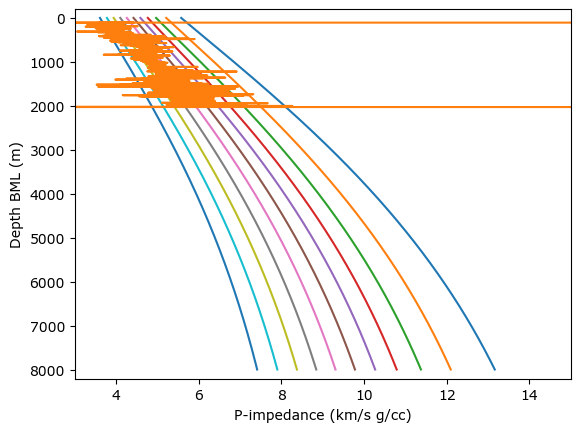

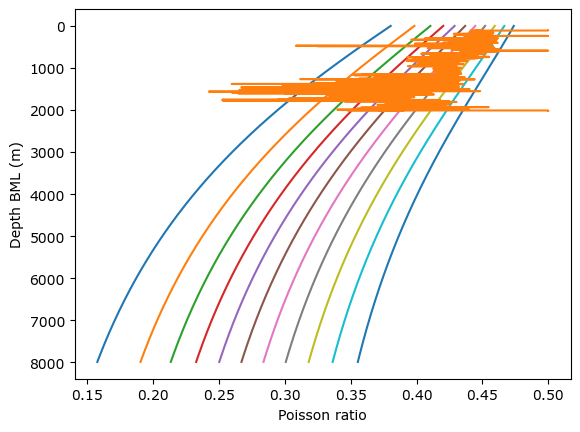

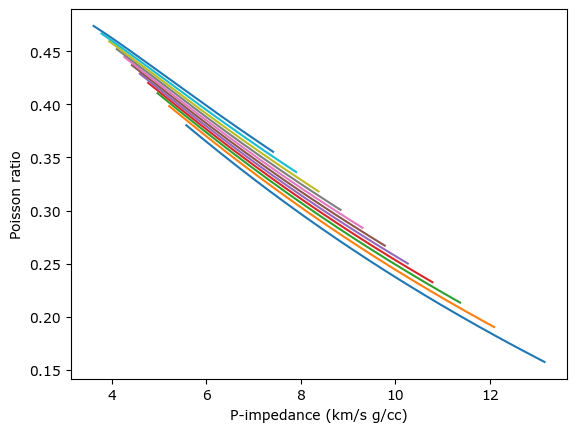

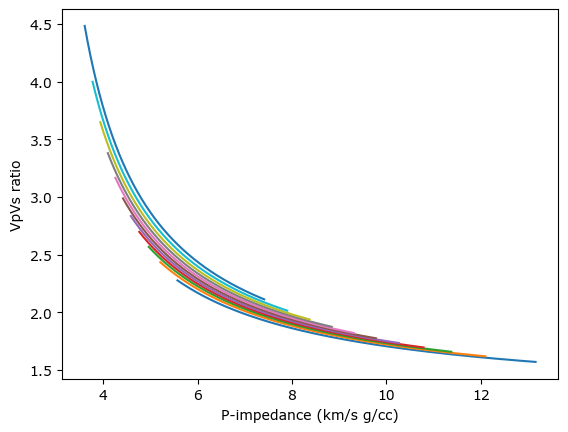

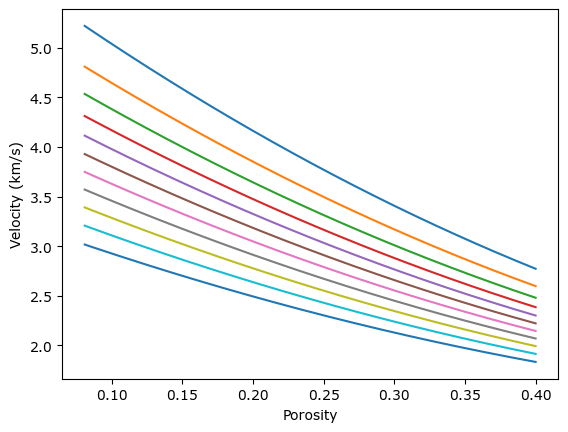

In [6]:
# Sand RPT using RHG eq

from vpvs2pr import vpvs2pr

k1=36.6 # Bulk Modulus of quartz, Gpa
g1=45 # Shear Modulus of quartz, Gpa
d1=2.65 # Density of quartz, g/cc
k2=21 # Bulk Modulus of clay, Gpa
g2=7 # Shear Modulus of clay, Gpa
d2=2.58 # Density of clay, g/cc
kf=2.6891 # Water Bulk Modulus, Gpa
rhof=1.05 # Density of Water, g/cc

# Porisity trend, Athy's eq, to be calibrated

phi0=0.4
c0=0.0002
phi=phi0*np.exp(-c0*zbml) # sand porosity trend, Athy eq

# Calculate vp_sand vs vclay
vclay=np.arange(0,1.1,0.1) # Define vclay array

kr=((1-vclay)/k1+vclay/k2)**(-1)
kv=k1*(1-vclay)+k2*vclay
kh=(kr+kv)/2
# kh=kr # fake soft sand model

gr=((1-vclay)/g1+vclay/g2)**(-1)
gv=g1*(1-vclay)+g2*vclay
gh=(gr+gv)/2
# gh=gr # fake soft sand model

ds=(1-vclay)*d1+vclay*d2 # Solid phase density, g/cc
vps=((kh+gh*4/3)/ds)**0.5 # Solid phase vp, km/s
vpf=1.5 # water vp, km/s

plt.figure()
plt.plot(vclay,kr,label='reuss')
plt.plot(vclay,kv,label='voight')
plt.plot(vclay,kh,label='hill')
plt.xlabel('Clay content')
plt.ylabel('Bulk modulus (gpa)')
plt.legend()

plt.figure()
plt.plot(vclay,gr,label='reuss')
plt.plot(vclay,gv,label='voight')
plt.plot(vclay,gh,label='hill')
plt.xlabel('Clay content')
plt.ylabel('Shear modulus (gpa)')
plt.legend()

plt.figure()
plt.plot(vclay,vps)
plt.xlabel('Clay content')
plt.ylabel('Vp solid (km/s)')

vp_sand=np.zeros((len(phi),len(vclay)))
for i in range(len(vclay)):
    vp_sand[:,i]=(1-phi)**2*vps[i]+phi*vpf

plt.figure()
plt.plot(phi,zbml)
plt.xlabel('Porosity')
plt.ylabel('Depth BML (m)')
plt.gca().invert_yaxis()

plt.figure()
plt.plot(vp_sand,zbml)
plt.plot(vp_sonic/1000,z-wd)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Depth BML (m)')
plt.gca().invert_yaxis()

# Calculate ro_sand, ip_sand, and pr_sand

ro_sand=np.zeros((len(phi),len(vclay)))
for i in range(len(vclay)):
    ro_sand[:,i]=phi*rhof+(1-phi)*ds[i]

plt.figure()
plt.plot(ro_sand,zbml)
plt.plot(rhob,z-wd)
plt.xlabel('Density (g/cc)')
plt.ylabel('Depth BML (m)')
plt.axis([1,3,-200,8200])
plt.gca().invert_yaxis()

ip_sand=vp_sand*ro_sand

plt.figure()
plt.plot(ip_sand,zbml)
plt.plot(vp_sonic*rhob/1000,z-wd)
plt.xlabel('P-impedance (km/s g/cc)')
plt.ylabel('Depth BML (m)')
plt.axis([3,15,-200,8200])
plt.gca().invert_yaxis()

vs_sand=(0.862*(vp_sand)-1.172) # km/s, Castagna Mudrock line

vpvs_sand=vp_sand/vs_sand
pr_sand=vpvs2pr(vpvs_sand)

plt.figure()
plt.plot(pr_sand,zbml)
plt.plot(pr_data,z-wd)
plt.xlabel('Poisson ratio')
plt.ylabel('Depth BML (m)')
plt.gca().invert_yaxis()

plt.figure()
plt.plot(ip_sand,pr_sand)
plt.xlabel('P-impedance (km/s g/cc)')
plt.ylabel('Poisson ratio')

plt.figure()
plt.plot(ip_sand,vpvs_sand)
plt.xlabel('P-impedance (km/s g/cc)')
plt.ylabel('VpVs ratio')

plt.figure()
plt.plot(phi,vp_sand)
plt.xlabel('Porosity')
plt.ylabel('Velocity (km/s)')



(3.0, 14.0, 1.5, 4.5)

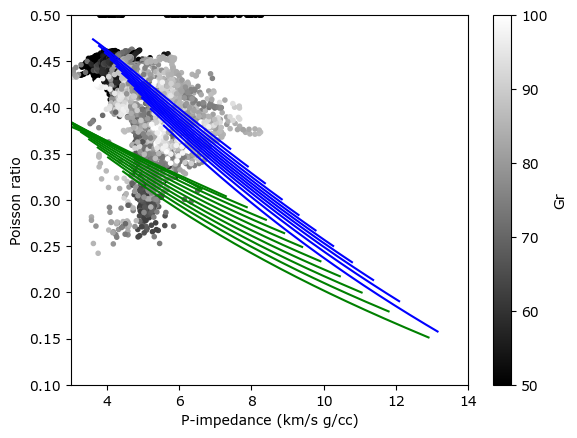

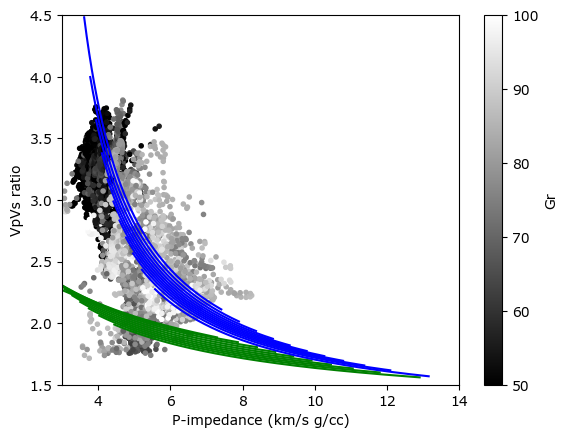

In [7]:
# Fluid sub using Gassmann eq
from gassmnv import gassmnv

rhof2=0.21 # Density of oil mixture, g/cc
kf2=0.19 # Bulk modulus of oil mixture, Gpa

phi_sand=np.zeros((len(phi),len(vclay)))
for i in range(len(vclay)):
    phi_sand[:,i]=phi

vp2, vs2, ro2, k2 = gassmnv(vp_sand, vs_sand, ro_sand, rhof, kf, rhof2, kf2, kh, phi_sand) # Doing fluid sub with Gassmann eq

ip2=vp2*ro2
vpvs2=vp2/vs2
pr2=vpvs2pr(vpvs2)

plt.figure()
plt.plot(ip2,pr2,'g')
plt.plot(ip_sand,pr_sand,'b')
#plt.plot(vp_sonic*rhob/1000,pr_data,'.')
plt.scatter(vp_sonic*rhob/1000, pr_data,c=gar,cmap='gray',marker='.', vmin=50, vmax=100)
plt.colorbar(label='Gr')
plt.xlabel('P-impedance (km/s g/cc)')
plt.ylabel('Poisson ratio')
plt.axis([3,14,0.1,0.5])

plt.figure()
plt.plot(ip2,vpvs2,'g')
plt.plot(ip_sand,vpvs_sand,'b')
plt.scatter(vp_sonic*rhob/1000, vpvs_data,c=gar,cmap='gray',marker='.', vmin=50, vmax=100)
plt.colorbar(label='Gr')
plt.xlabel('P-impedance (km/s g/cc)')
plt.ylabel('VpVs ratio')
plt.axis([3,14,1.5,4.5])


In [8]:
print(phi_sand.shape)

(800, 11)


In [9]:
print(gr.shape)

(11,)


(12,)


(3.0, 14.0, 1.5, 4.5)

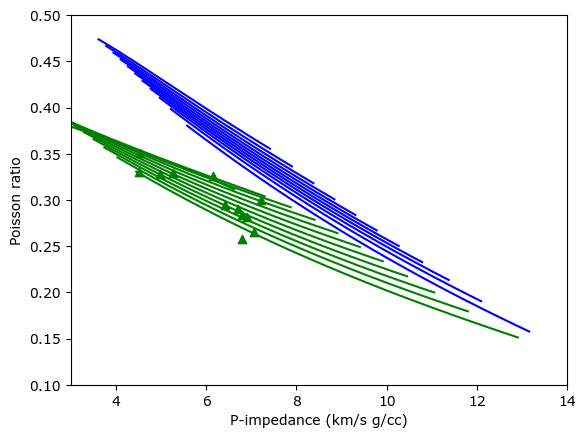

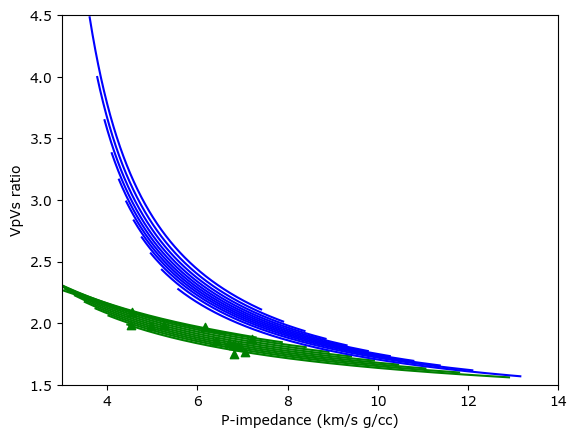

In [10]:
from pr2vpvs import pr2vpvs

# Import more ai and pr data to plot. Note here need to convert list to np array before plot

ai_data = [4979, 5252, 6802, 6421, 6701, 7052, 6157, 6788, 6902, 7215, 4518, 4538]  # reservoir rock sample
pr_data2 = [0.3281, 0.3295, 0.2577, 0.295, 0.2903, 0.2654, 0.3254, 0.2841, 0.2812, 0.3, 0.3297, 0.3511]  # reservoir rock sample
ai_data_array = np.array(ai_data)
pr_data_array = np.array(pr_data2)

print(pr_data_array.shape)

vpvs_data_array=pr2vpvs(pr_data_array)

plt.figure()
plt.plot(ip2,pr2,'g')
plt.plot(ip_sand,pr_sand,'b')
#plt.plot(vp_sonic*rhob/1000,pr_data,'.')
plt.scatter(ai_data_array/1000, pr_data_array,marker='^', color='g')
plt.xlabel('P-impedance (km/s g/cc)')
plt.ylabel('Poisson ratio')
plt.axis([3,14,0.1,0.5])

plt.figure()
plt.plot(ip2,vpvs2,'g')
plt.plot(ip_sand,vpvs_sand,'b')
plt.scatter(ai_data_array/1000, vpvs_data_array, marker='^', color='g')
plt.xlabel('P-impedance (km/s g/cc)')
plt.ylabel('VpVs ratio')
plt.axis([3,14,1.5,4.5])
